In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, confusion_matrix
set_config(display='diagram')

In [35]:
df = pd.read_csv('Customers.csv')
df

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,Male,19,15000,39,Healthcare,1,4
1,2,Male,21,35000,81,Engineer,3,3
2,3,Female,20,86000,6,Engineer,1,1
3,4,Female,23,59000,77,Lawyer,0,2
4,5,Female,31,38000,40,Entertainment,2,6
...,...,...,...,...,...,...,...,...
1995,1996,Female,71,184387,40,Artist,8,7
1996,1997,Female,91,73158,32,Doctor,7,7
1997,1998,Male,87,90961,14,Healthcare,9,2
1998,1999,Male,77,182109,4,Executive,7,2


In [36]:
df.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual Income ($)',
       'Spending Score (1-100)', 'Profession', 'Work Experience',
       'Family Size'],
      dtype='object')

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              2000 non-null   int64 
 1   Gender                  2000 non-null   object
 2   Age                     2000 non-null   int64 
 3   Annual Income ($)       2000 non-null   int64 
 4   Spending Score (1-100)  2000 non-null   int64 
 5   Profession              1965 non-null   object
 6   Work Experience         2000 non-null   int64 
 7   Family Size             2000 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 125.1+ KB


In [38]:
df.isna().sum()

CustomerID                 0
Gender                     0
Age                        0
Annual Income ($)          0
Spending Score (1-100)     0
Profession                35
Work Experience            0
Family Size                0
dtype: int64

In [39]:
df.describe()

,CustomerID,Age,Annual Income ($),Spending Score (1-100),Work Experience,Family Size
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1000.500000,48.960000,110731.821500,50.962500,4.102500,3.768500
std,577.494589,28.429747,45739.536688,27.934661,3.922204,1.970749
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,500.750000,25.000000,74572.000000,28.000000,1.000000,2.000000
50%,1000.500000,48.000000,110045.000000,50.000000,3.000000,4.000000
75%,1500.250000,73.000000,149092.750000,75.000000,7.000000,5.000000
max,2000.000000,99.000000,189974.000000,100.000000,17.000000,9.000000


In [40]:
df['Profession'].unique()

array(['Healthcare', 'Engineer', 'Lawyer', 'Entertainment', 'Artist',
       'Executive', 'Doctor', 'Homemaker', 'Marketing', nan], dtype=object)

# Pipeline build

In [41]:
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin

colclust = ['Gender', 'Age', 'Profession', 'Work Experience','Family Size']

class SetAge(BaseEstimator, ClassifierMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(X[X['Age']<18].index)
    
class DropnaProfession(BaseEstimator, ClassifierMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.dropna(subset=['Profession'])
    
class DropColCustID(BaseEstimator, ClassifierMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(columns=['CustomerID'])

class DropCol(BaseEstimator, ClassifierMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(columns=colclust)
    
class LabelEnc(BaseEstimator, TransformerMixin):
    def __init__(self, cat_col):
        self.cat_col = cat_col
        self.label_encoders = {}

    def fit(self, X, y=None):
        for col in self.cat_col:
            self.label_encoders[col] = LabelEncoder()
            self.label_encoders[col].fit(X[col])
        return self

    def transform(self, X):
        X_encoded = X.copy()
        for col in self.cat_col:
            X_encoded[col] = self.label_encoders[col].transform(X[col])
        return X_encoded
    
class OneHotEnc(BaseEstimator, TransformerMixin):
    def __init__(self, col):
        self.col = col
        self.ohe = OneHotEncoder()
    def fit(self, X, y=None):
        self.ohe.fit(X[self.col])
        return self
    def transform(self, X):
        X_enc = self.ohe.fit_transform(X[self.col])
        X_enc_df = pd.DataFrame(X_enc.toarray(), columns=self.ohe.get_feature_names_out(self.col))
        X.drop(columns=self.col, inplace=True)
        X = pd.concat([X, X_enc_df], axis=1)
        return X
    
class GetDummies(BaseEstimator, TransformerMixin):
    def __init__(self, col):
        self.col = col
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return pd.get_dummies(X, columns=self.col)

In [42]:
num_col = ['Age', 'Annual Income ($)', 'Spending Score (1-100)', 'Work Experience', 'Family Size']
cat_col = ['Gender', 'Profession']

scaler = MinMaxScaler()

# Cleaning pipe
num_pipe = Pipeline([
    ('scaler', scaler)
])

cat_pipe = Pipeline([
    ('encode', LabelEnc(['Gender'])),
#     ('ohe', OneHotEnc(['Profession']))
    ('get_dummies', GetDummies(['Profession']))
])

clean = Pipeline([
    ('dropCustID', DropColCustID()),
    ('AgeSet', SetAge()),
    ('dropnaProfession', DropnaProfession())
])

# clustering pipe
clustering = Pipeline([
    ('dropcol', DropCol()),
    ('scaler', num_pipe),
    ('kmeans', KMeans(n_clusters=2, random_state=42))
])


#clasification pipe
preprocessor = ColumnTransformer([
    ('num', num_pipe, num_col),
    ('cat', cat_pipe, cat_col)
])

lg_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('LogReg', LogisticRegression())
])


In [43]:
clean

Pipeline(steps=[('dropCustID', DropColCustID()), ('AgeSet', SetAge()),
                ('dropnaProfession', DropnaProfession())])

In [44]:
r = clean.fit_transform(df)
r

,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,Male,19,15000,39,Healthcare,1,4
1,Male,21,35000,81,Engineer,3,3
2,Female,20,86000,6,Engineer,1,1
3,Female,23,59000,77,Lawyer,0,2
4,Female,31,38000,40,Entertainment,2,6
...,...,...,...,...,...,...,...
1995,Female,71,184387,40,Artist,8,7
1996,Female,91,73158,32,Doctor,7,7
1997,Male,87,90961,14,Healthcare,9,2
1998,Male,77,182109,4,Executive,7,2


# Predict Cluster

In [45]:
clustering

Pipeline(steps=[('dropcol', DropCol()),
                ('scaler', Pipeline(steps=[('scaler', MinMaxScaler())])),
                ('kmeans', KMeans(n_clusters=2, random_state=42))])

In [46]:
c = clustering.fit_predict(r)
r['Cluster'] = c
r

,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size,Cluster
0,Male,19,15000,39,Healthcare,1,4,0
1,Male,21,35000,81,Engineer,3,3,1
2,Female,20,86000,6,Engineer,1,1,0
3,Female,23,59000,77,Lawyer,0,2,1
4,Female,31,38000,40,Entertainment,2,6,0
...,...,...,...,...,...,...,...,...
1995,Female,71,184387,40,Artist,8,7,0
1996,Female,91,73158,32,Doctor,7,7,0
1997,Male,87,90961,14,Healthcare,9,2,0
1998,Male,77,182109,4,Executive,7,2,0


# tunning cluster

In [47]:
clustering.get_params()

{'memory': None,
 'steps': [('dropcol', DropCol()),
  ('scaler', Pipeline(steps=[('scaler', MinMaxScaler())])),
  ('kmeans', KMeans(n_clusters=2, random_state=42))],
 'verbose': False,
 'dropcol': DropCol(),
 'scaler': Pipeline(steps=[('scaler', MinMaxScaler())]),
 'kmeans': KMeans(n_clusters=2, random_state=42),
 'scaler__memory': None,
 'scaler__steps': [('scaler', MinMaxScaler())],
 'scaler__verbose': False,
 'scaler__scaler': MinMaxScaler(),
 'scaler__scaler__clip': False,
 'scaler__scaler__copy': True,
 'scaler__scaler__feature_range': (0, 1),
 'kmeans__algorithm': 'auto',
 'kmeans__copy_x': True,
 'kmeans__init': 'k-means++',
 'kmeans__max_iter': 300,
 'kmeans__n_clusters': 2,
 'kmeans__n_init': 10,
 'kmeans__random_state': 42,
 'kmeans__tol': 0.0001,
 'kmeans__verbose': 0}

In [48]:
#tuning kmeans
param = {
    'kmeans__n_clusters':[2,3]
}

#CV tuning kmeans
grid_search = GridSearchCV(clustering,param,cv=5)
grid_search.fit(df)

#result tuning
best_params = grid_search.best_params_
best_n_cluster = best_params['kmeans__n_clusters']
print('best cluster:', best_n_cluster)

#fit pipeline
clustering.set_params(kmeans__n_clusters=best_n_cluster)

cluster = clustering.fit_predict(r)
r['Cluster'] = cluster
r

best cluster: 3


,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size,Cluster
0,Male,19,15000,39,Healthcare,1,4,2
1,Male,21,35000,81,Engineer,3,3,0
2,Female,20,86000,6,Engineer,1,1,2
3,Female,23,59000,77,Lawyer,0,2,0
4,Female,31,38000,40,Entertainment,2,6,2
...,...,...,...,...,...,...,...,...
1995,Female,71,184387,40,Artist,8,7,1
1996,Female,91,73158,32,Doctor,7,7,2
1997,Male,87,90961,14,Healthcare,9,2,2
1998,Male,77,182109,4,Executive,7,2,1


# EDA

## Target

In [49]:
r.Cluster.value_counts()

0    789
2    458
1    391
Name: Cluster, dtype: int64

## Age vs Target

C:\Users\a s u s\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\a s u s\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\a s u s\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an ax

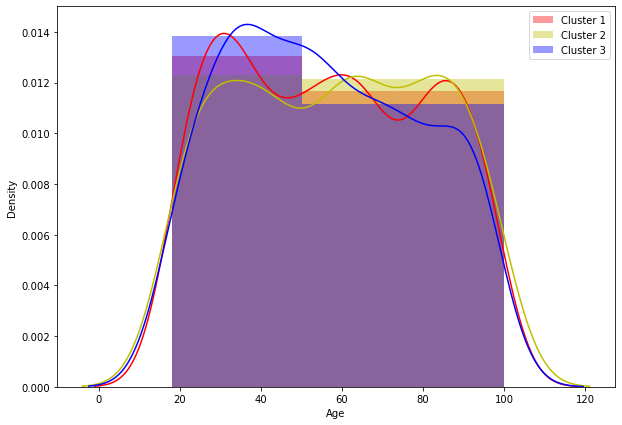

In [50]:
plt.figure(figsize=[10,7])
sns.distplot(r.Age[r.Cluster==0], bins=[0,5,18,50,100], color='r', label='Cluster 1')
sns.distplot(r.Age[r.Cluster==1], bins=[0,5,18,50,100], color='y', label='Cluster 2')
sns.distplot(r.Age[r.Cluster==2], bins=[0,5,18,50,100], color='b', label='Cluster 3')
plt.legend()

Cluster distribution based on age appears even across all ages. There is no specific age range that dominates a particular cluster.

## Income vs Target

C:\Users\a s u s\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\a s u s\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\a s u s\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an ax

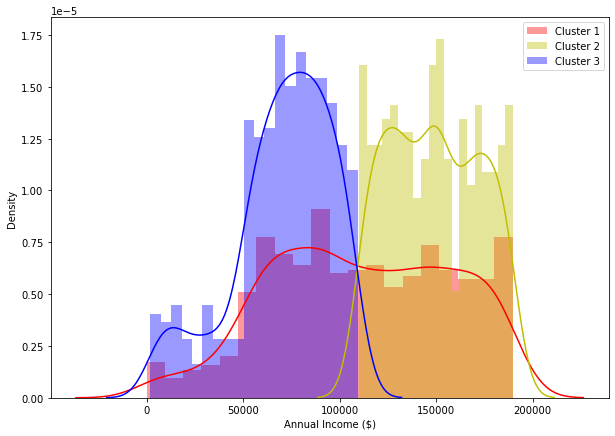

In [51]:
plt.figure(figsize=(10,7))
sns.distplot(r['Annual Income ($)'][r.Cluster==0], bins=20, color='r', label='Cluster 1')
sns.distplot(r['Annual Income ($)'][r.Cluster==1], bins=20, color='y', label='Cluster 2')
sns.distplot(r['Annual Income ($)'][r.Cluster==2], bins=20, color='b', label='Cluster 3')
plt.legend()

Annual income range 50000-100000 mostly falls into cluster 3, annual income range 100000-200000 mostly falls into cluster 2, while some individuals with annual income range 50000-170000 are placed in cluster 1.

##  Spending Score vs Target

C:\Users\a s u s\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\a s u s\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\a s u s\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an ax

<AxesSubplot:xlabel='Spending Score (1-100)', ylabel='Density'>

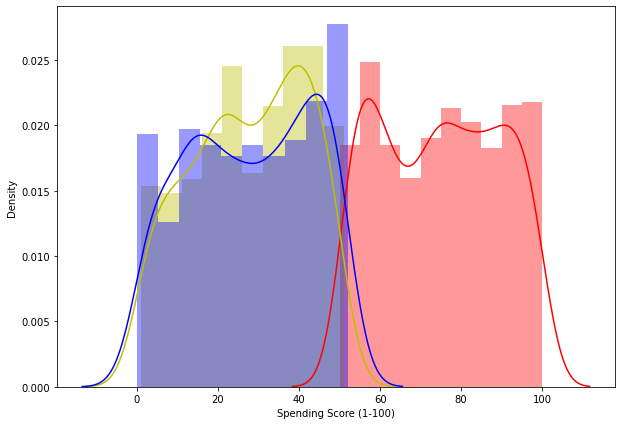

In [52]:
plt.figure(figsize=(10,7))
sns.distplot(r['Spending Score (1-100)'][r.Cluster==0], bins=10, color='r', label='Cluster 1')
sns.distplot(r['Spending Score (1-100)'][r.Cluster==1], bins=10, color='y', label='Cluster 2')
sns.distplot(r['Spending Score (1-100)'][r.Cluster==2], bins=10, color='b', label='Cluster 3')


Spending score >50 tends to be present in cluster 1, while spending score <50 is evenly distributed between cluster 2 and cluster 3.

## Categorical vs Target

C:\Users\a s u s\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\a s u s\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


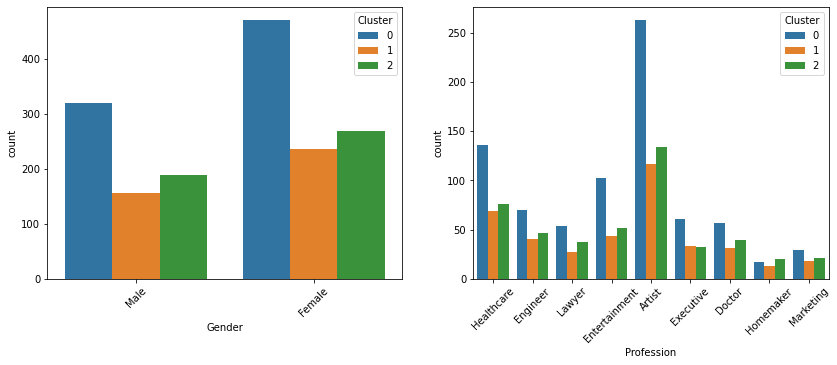

In [53]:
cat_col = ['Gender', 'Profession']

fig, axes = plt.subplots(1,2, figsize=(14,5))
for cat,ax in zip(cat_col, axes.flatten()):
    sns.countplot(cat, data=r, hue='Cluster', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45) 

Both females and males are more prevalent in cluster 1, and there is no significant correlation observed with the profession plot.

In [54]:
r.Profession.value_counts()

Artist           514
Healthcare       281
Entertainment    197
Engineer         157
Doctor           127
Executive        126
Lawyer           118
Marketing         68
Homemaker         50
Name: Profession, dtype: int64

# Clasification using Logistic Regression

In [55]:
lg_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'Annual Income ($)',
                                                   'Spending Score (1-100)',
                                                   'Work Experience',
                                                   'Family Size']),
                                                 ('cat',
                                                  Pipeline(steps=[('encode',
                                                                   LabelEnc(cat_col=['Gender'])),
                                                                  ('get_dummies',
                                                                   GetDummies(col=['Profession']))]),
                                                  ['Gender', 'Profession'])])),
                ('LogReg', LogisticRegression())])

In [56]:
X = r.drop(columns='Cluster')
y = r['Cluster']

X

,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,Male,19,15000,39,Healthcare,1,4
1,Male,21,35000,81,Engineer,3,3
2,Female,20,86000,6,Engineer,1,1
3,Female,23,59000,77,Lawyer,0,2
4,Female,31,38000,40,Entertainment,2,6
...,...,...,...,...,...,...,...
1995,Female,71,184387,40,Artist,8,7
1996,Female,91,73158,32,Doctor,7,7
1997,Male,87,90961,14,Healthcare,9,2
1998,Male,77,182109,4,Executive,7,2


In [57]:
#split train, val, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1146, 7) (492, 7) (1146,) (492,)


In [58]:
lg_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'Annual Income ($)',
                                                   'Spending Score (1-100)',
                                                   'Work Experience',
                                                   'Family Size']),
                                                 ('cat',
                                                  Pipeline(steps=[('encode',
                                                                   LabelEnc(cat_col=['Gender'])),
                                                                  ('get_dummies',
                                                                   GetDummies(col=['Profession']))]),
                                                  ['Gender', 'Profession'])])),
                ('LogReg', LogisticRegression())])

In [59]:
lgpred = lg_pipe.predict(X_test)

In [60]:
acc_score = accuracy_score(y_test, lgpred)
cm = confusion_matrix(y_test, lgpred)

print('accuracy: ', acc_score)
print('confusion matrix: \n', cm)

accuracy:  0.9247967479674797
confusion matrix: 
 [[222   7   8]
 [  9 105   3]
 [ 10   0 128]]


# Tunning LG

In [61]:
lg_pipe.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('scaler', MinMaxScaler())]),
                                    ['Age', 'Annual Income ($)',
                                     'Spending Score (1-100)', 'Work Experience',
                                     'Family Size']),
                                   ('cat',
                                    Pipeline(steps=[('encode',
                                                     LabelEnc(cat_col=['Gender'])),
                                                    ('get_dummies',
                                                     GetDummies(col=['Profession']))]),
                                    ['Gender', 'Profession'])])),
  ('LogReg', LogisticRegression())],
 'verbose': False,
 'preprocessor': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('scaler', MinMaxScaler())]),
                        

In [62]:
params = {
    'LogReg__C' : [0.01, 0.1, 1, 10],
    'LogReg__max_iter' : [100, 500, 1000],
    'LogReg__penalty' : ['l1', 'l2'],
    'LogReg__solver' : ['lbfgs', 'liblinear', 'sag', 'saga'],
    'LogReg__class_weight' : ['None','balanced']
}

gs = GridSearchCV(lg_pipe,params,cv=5)
gs.fit(X_train, y_train)

#result tuning
best_params = gs.best_params_
print('best parameter:', best_params)

#fit pipeline
lg_pipe.set_params(**best_params)

C:\Users\a s u s\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a s u s\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a s u s\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a s u s\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a s u s\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a s u s\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: T

best parameter: {'LogReg__C': 10, 'LogReg__class_weight': 'balanced', 'LogReg__max_iter': 1000, 'LogReg__penalty': 'l1', 'LogReg__solver': 'saga'}


C:\Users\a s u s\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'Annual Income ($)',
                                                   'Spending Score (1-100)',
                                                   'Work Experience',
                                                   'Family Size']),
                                                 ('cat',
                                                  Pipeline(steps=[('encode',
                                                                   LabelEnc(cat_col=['Gender'])),
                                                                  ('get_dummies',
                                                                   GetDummies(col=['Profession']))]),
                                                  ['Gender', 'Profession'])])),
                ('LogReg',
                 LogisticRegression(C=10, class_weight='balanced',
                                    max_iter=1000, penalty='l1',
                                    solver='saga'))])

In [63]:
lg_pipe.fit(X_train, y_train)

tunning_pred = lg_pipe.predict(X_test)

C:\Users\a s u s\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [64]:
acc_score = accuracy_score(y_test, tunning_pred)
cm = confusion_matrix(y_test, tunning_pred)

print('accuracy: ', acc_score)
print('confusion matrix: \n', cm)

accuracy:  0.975609756097561
confusion matrix: 
 [[230   5   2]
 [  1 116   0]
 [  3   1 134]]
